# **Waze**



# **Random Forest and XGBoost**

**The purpose** of this model is to find factors that drive user churn.

**The goal** of this model is to predict whether or not a Waze user is retained or churned.
<br/>

*This Notebook has three parts:*

**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps



# **PACE stages**


## **PACE: Plan**




**In this stage, consider the following questions:**

1. **What are you being asked to do?**
   
   I am being asked to recognize people that are inclined to leave the app.

2. **What are the ethical implications of the model? What are the consequences of your model making errors?**
   - *What is the likely effect of the model when it predicts a false negative (i.e., when the model says a Waze user won't churn, but they actually will)?*
     
     The effect of having false negatives is that the model will stop recognizing people that want to leave and so we'll not invest in campaigns for them to stay.
     
   - *What is the likely effect of the model when it predicts a false positive (i.e., when the model says a Waze user will churn, but they actually won't)?*
   
     Having false positives means that people that never intended to leave are going to be labeled as they were, and thus we'll invest resources unnecessarily on them.

3. **Do the benefits of such a model outweigh the potential problems?**
   
   It depends on the company's intention. If it thinks that it can bear the loss of some customers if others stay, then we can afford to have false negatives. On the contrary, if it thinks that It would be worth to spend a bit more even on people that are not prompt to leave in order to have customers staying, then we can work with more false positives.

4. **Would you proceed with the request to build this model? Why or why not?**
   
   The proactive measures taken by Waze might have unintended effects on users, and these effects might encourage user churn. For example, people who were thinking of leaving who were not recognized as such can feel that they are left behind with no promotions that others have. Also, the company might push notifications for people that were loyal and annoy them to leave. Follow-up analysis on the effectiveness of the measures is recommended. If the measures are reasonable and effective, then the benefits will most likely outweigh the problems.



### **Task 1. Imports and data loading**

Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt

from xgboost import XGBClassifier, plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier

import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/MyDrive/Data Analytics/Main Projects/Waze project/waze_dataset.csv'
df0 = pd.read_csv(file_path)
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


## **PACE: Analyze**

### **Task 2. Feature engineering**

This data has been prepared and some exploratory data analysis (EDA) has been performed on it in previous notebooks. It is known that some features had stronger correlations with churn than others, and so some useful features were created.

In [6]:
df = df0.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [7]:
def engineer_feature(df_, feature:str, numerators:list, denominators:list):
  df_[feature] = df_[numerators].sum(axis=1)/ df_[denominators].sum(axis=1)
  return df_[feature].describe()

def fix_inf(df_, col_1, col_2, new_value):
  df_.loc[df[col_1] == np.inf, col_2] = new_value
  return df_[col_2].describe()

#### **`km_per_driving_day`**

1. Creating a feature representing the mean number of kilometers driven on each driving day in the last month for each user:


In [8]:
engineer_feature(df,"km_per_driving_day",["driven_km_drives"],["driving_days"])

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Notice that some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

1. Converting these values from infinity to zero. You can use `np.inf` to refer to a value of infinity:


In [9]:
fix_inf(df,"km_per_driving_day","km_per_driving_day",0)

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`**

1. Creating a new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use:


In [10]:
engineer_feature(df,"percent_sessions_in_last_month",["sessions"],["total_sessions"])

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

#### **`professional_driver`**

Creating a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

**Note:** The objective is to create a new feature that separates professional drivers from other drivers. In this scenario, domain knowledge and intuition are used to determine these deciding thresholds, but ultimately they are arbitrary.

In [11]:
df["professional_driver"] = np.where((df["drives"]>=60)&(df["driving_days"]>=15) ,1,0)

#### **`total_sessions_per_day`**

Creating a new column that represents the mean number of sessions per day _since onboarding_:

In [12]:
engineer_feature(df,"total_sessions_per_day",["total_sessions"],["n_days_after_onboarding"])

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**

Creating a column representing the mean kilometers per hour driven in the last month:

In [13]:
df["km_per_hour"] = df["driven_km_drives"] / (df["duration_minutes_drives"] / 60)
df["km_per_hour"].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

These numbers are obviously problematic, and it would be worthwhile to seek clarification from Waze regarding how these features are collected to better understand why such unrealistic speeds are observed.

#### **`km_per_drive`**

Creating a column representing the mean number of kilometers per drive made in the last month for each user. Then, print descriptive statistics for the feature.

In [14]:
engineer_feature(df,"km_per_drive",["driven_km_drives"],["drives"])

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

This feature has infinite values too. Convert the infinite values to zero, then confirm that it worked.

In [15]:
fix_inf(df,"km_per_drive",'km_per_drive',0)

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

Creating a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [16]:
engineer_feature(df,"percent_of_sessions_to_favorite",["total_navigations_fav1","total_navigations_fav2"],["total_sessions"])

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_sessions_to_favorite, dtype: float64

### **Task 3. Drop missing values**

It is known from previous EDA that there is no evidence of a non-random cause of the 700 missing values in the `label` column, and because these observations comprise less than 5% of the data, we are dropping the rows that are missing this data:

In [17]:
df.dropna(subset=['label'],inplace=True)

### **Task 4. Outliers**

It's known from previous EDA that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

### **Task 5. Variable encoding**

#### **Dummying features**



In [18]:
df["device2"] = np.where(df["device"]=="Android", 0, 1)

In [19]:
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


#### **Target encoding**


In [20]:
df["label2"] = np.where(df["label"]=="churned", 1, 0)

In [21]:
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### **Task 6. Feature selection**

Tree-based models can handle multicollinearity, so the only feature that can be cut is `ID`, since it doesn't contain any information relevant to churn.

Note, however, that `device` won't be used simply because it's a copy of `device2`.

Dropping `ID` from the `df` dataframe.

In [22]:
df.drop(["ID"],axis=1,inplace=True)

### **Task 7. Evaluation metric**

Before modeling, an evaluation metric must be chosen. This will depend on the class balance of the target variable and the use case of the model.

Examining the class balance of your target variable:

In [23]:
df["label2"].value_counts(normalize=True)

0    0.822645
1    0.177355
Name: label2, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

Now, consider which evaluation metric is best. Remember, accuracy might not be the best gauge of performance because a model can have high accuracy on an imbalanced dataset and still fail to predict the minority class.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, select the model based on the recall score.

## **PACE: Construct**


### **Task 8. Modeling workflow and model selection process**

The final modeling dataset contains 14,299 samples. This is towards the lower end of what might be considered sufficient to conduct a robust model selection process, but still doable.

1. Split the data into train/validation/test sets (60/20/20)

Note that, when deciding the split ratio and whether or not to use a validation set to select a champion model, consider both how many samples will be in each data partition, and how many examples of the minority class each would therefore contain. In this case, a 60/20/20 split would result in \~2,860 samples in the validation set and the same number in the test set, of which \~18%&mdash;or 515 samples&mdash;would represent users who churn.
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)

### **Task 9. Split the data**

Splitting the data 80/20 into an interim training set and a test set and then the interim training set 75/25 into a training set and a validation set, yielding a final ratio of 60/20/20 for training/validation/test sets:

In [24]:
X = df.drop(columns=["label","label2","device"])

y = df["label2"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_tr, X_val, y_tr,  y_val =  train_test_split(X_train, y_train, stratify = y_train, test_size=0.25,random_state=42)

Verifying the number of samples in the partitioned data.

In [25]:
for x in [X_tr,X_test,X_val]:
  print(len(x))

8579
2860
2860


This aligns with expectations.

### **Task 10. Modeling**

#### **Random forest**


In [26]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42,class_weight='balanced')

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

Now fit the model to the training data.

In [27]:
%%time
rf_cv.fit(X_tr, y_tr)

CPU times: user 2min 14s, sys: 103 ms, total: 2min 14s
Wall time: 2min 20s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring={'f1', 'accuracy', 'precision', 'recall'})

Examining the best average score across all the validation folds.

In [28]:
rf_cv.best_score_

0.14650849564857024

Examining the best combination of hyperparameters.

In [29]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of the model. Note that the function accepts three arguments.

In [30]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''
    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'Accuracy': [accuracy],
                          'Precision': [precision],
                          'Recall': [recall],
                          'F1': [f1],
                         }
                        )

    return table

Pass the `GridSearch` object to the `make_results()` function.

In [31]:
rf_cv_results = make_results('Random Forest CV', rf_cv,'recall')
rf_cv_results

,Model,Accuracy,Precision,Recall,F1
0,Random Forest CV,0.814198,0.431921,0.146508,0.218282


Asside from the accuracy, the scores aren't that good. However, remember that the logistic regression model had a recall of \~0.09, which means that this model has 38% better recall and about the same accuracy, and it was trained on less data.


#### **XGBoost**

Don't forget to set `objective='binary:logistic'` and `refit='recall'`.

In [32]:
# 1. Instantiate the XGBoost classifier
scale_pos_weight = 1 / 0.177355
xgb = XGBClassifier(objective='binary:logistic', random_state=42,scale_pos_weight=scale_pos_weight)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

Now fit the model.

Note this cell might take several minutes to run.

In [33]:
%%time
xgb_cv.fit(X_tr, y_tr)

CPU times: user 3min 3s, sys: 830 ms, total: 3min 4s
Wall time: 1min 45s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring={'f1', 'accuracy', 'precision', 'recall'})

Get the best score from this model.

In [34]:
xgb_cv.best_score_

0.6747668876916701

And the best parameters.

In [35]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model.

In [36]:
xgb_cv_results = make_results('XGBoost CV', xgb_cv,'recall')
results = pd.concat([xgb_cv_results,rf_cv_results], axis=0)
results

,Model,Accuracy,Precision,Recall,F1
0,XGBoost CV,0.688309,0.320398,0.674767,0.434448
0,Random Forest CV,0.814198,0.431921,0.146508,0.218282


This model fit the data much better than the random forest model. The recall score is nearly 5 times greater, but it has reduced accuracy and precision.

### **Task 11. Model selection**

Using the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

#### **Random forest**

In [37]:
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

Use the `get_test_scores()` function to generate a table of scores from the predictions on the validation data.

In [38]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'Model': [model_name],
                          'Accuracy': [accuracy],
                          'Precision': [precision],
                          'Recall': [recall],
                          'F1': [f1],
                         }
                        )

    return table

In [39]:
rf_val_scores = get_test_scores('Random Forest val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([rf_val_scores,results], axis=0)
results

,Model,Accuracy,Precision,Recall,F1
0,Random Forest val,0.813986,0.426901,0.143984,0.215339
0,XGBoost CV,0.688309,0.320398,0.674767,0.434448
0,Random Forest CV,0.814198,0.431921,0.146508,0.218282


Notice that the scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

#### **XGBoost**

Now, do the same thing to get the performance scores of the XGBoost model on the validation data.

In [40]:
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

xgb_val_scores = get_test_scores('XGBoost val', xgb_val_preds, y_val)

results = pd.concat([xgb_val_scores, results], axis=0)
results

,Model,Accuracy,Precision,Recall,F1
0,XGBoost val,0.686713,0.323021,0.700197,0.442092
0,Random Forest val,0.813986,0.426901,0.143984,0.215339
0,XGBoost CV,0.688309,0.320398,0.674767,0.434448
0,Random Forest CV,0.814198,0.431921,0.146508,0.218282


The XGB's validation recall, precision, and F1 are even better than in the training model. This is clearly the champion model.


## **PACE: Execute**


### **Task 12. Use champion model to predict on test data**

Using the champion model to predict on the test dataset. This is to give a final indication of how you should expect the model to perform on new future data, should you decide to use the model:

In [41]:
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([xgb_test_scores, results], axis=0)
results

,Model,Accuracy,Precision,Recall,F1
0,XGB test,0.670979,0.301645,0.650888,0.412242
0,XGBoost val,0.686713,0.323021,0.700197,0.442092
0,Random Forest val,0.813986,0.426901,0.143984,0.215339
0,XGBoost CV,0.688309,0.320398,0.674767,0.434448
0,Random Forest CV,0.814198,0.431921,0.146508,0.218282


The difference between XGB test and XGBoost CV is not very pronounced, suggesting some consistency in the model's ability to identify positive cases in these two sets.

### **Task 13. Confusion matrix**

Plotting a confusion matrix of the champion model's predictions on the test data.

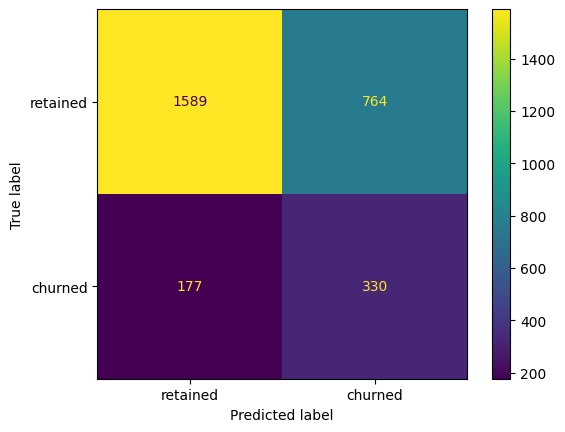

In [42]:
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

The model predicted 4 times as many false positives than it did false negatives. This means that it has many people not churning identified as they were going to, but also it failed to recognize some people that were churning. It correctly identified 65% of the users who actually churned.

### **Task 14. Feature importance**

Using the `plot_importance` function to inspect the most important features of the final model:

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

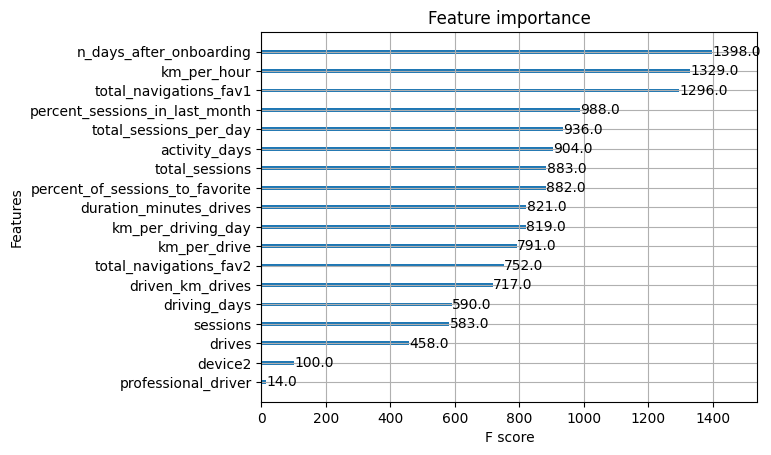

In [43]:
plot_importance(xgb_cv.best_estimator_)

The XGBoost model made more use of many of the features than did the logistic regression model from the previous Notebook, which weighted a single feature (`professional driver`) very heavily in its final prediction.

If anything, this underscores the importance of feature engineering. Notice that engineered features accounted for six of the top 10 features (and three of the top five). Feature engineering is often one of the best and easiest ways to boost model performance.

Also, note that the important features in one model might not be the same as the important features in another model. That's why you shouldn't discount features as unimportant without thoroughly examining them and understanding their relationship with the dependent variable, if possible. These discrepancies between features selected by models are typically caused by complex feature interactions.

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.

Even if you cannot use the model to make strong predictions, was the work done in vain? What insights can you report back to stakeholders?

### **Task 15. Conclusion**

Now that the machine learning models have been built and tested, the next step is to share the findings with the Waze leadership team. Consider the following questions:

**Questions:**
1. Would you recommend using this model for churn prediction? Why or why not?

> _Considering the consistent recall and overall comparable performance, the XGB model appears to be a reasonable candidate for churn prediction in Waze. However, it's crucial to weigh the trade-offs between precision and recall, and further fine-tune the model or adjust decision thresholds based on the specific requirements and business impact._

2. What tradeoff was made by splitting the data into training, validation, and test sets as opposed to just training and test sets?

> _Splitting the data three ways means that there is less data available to train the model than splitting just two ways. However, performing model selection on a separate validation set enables testing of the champion model by itself on the test set, which gives a better estimate of future performance than splitting the data two ways and selecting a champion model by performance on the test data._

3. What is the benefit of using a logistic regression model over an ensemble of tree-based models (like random forest or XGBoost) for classification tasks?

> _Logistic regression models are easier to interpret. Because they assign coefficients to predictor variables, they reveal not only which features factored most heavily into their final predictions, but also the directionality of the weight. In other words, they tell you if each feature is positively or negatively correlated with the target in the model's final prediction._

4. What is the benefit of using an ensemble of tree-based models like random forest or XGBoost over a logistic regression model for classification tasks?

> _Tree-based model ensembles are often better predictors. If the most important thing is the predictive power of the model, then tree-based modeling will usually win out against logistic regression (but not always!). They also require much less data cleaning and require fewer assumptions about the underlying distributions of their predictor variables, so they're easier to work with._

5. What could you do to improve this model?

> _New features could be engineered to try to generate better predictive signal, as they often do if you have domain knowledge. In the case of this model, the engineered features made up over half of the top 10 most-predictive features used by the model. It could also be helpful to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._

6. What additional features would you like to have to help improve the model?

> _It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs._

### **BONUS**


#### **Identifying an optimal decision threshold**

The default decision threshold for most implementations of classification algorithms&mdash;including scikit-learn's&mdash;is 0.5. This means that, in the case of the Waze models, if they predicted that a given user had a 50% probability or greater of churning, then that user was assigned a predicted value of `1`&mdash;the user was predicted to churn.

With imbalanced datasets where the response class is a minority, this threshold might not be ideal. A precision-recall curve can help to visualize the trade-off between the model's precision and recall.

Here's the precision-recall curve for the XGBoost champion model on the test data:

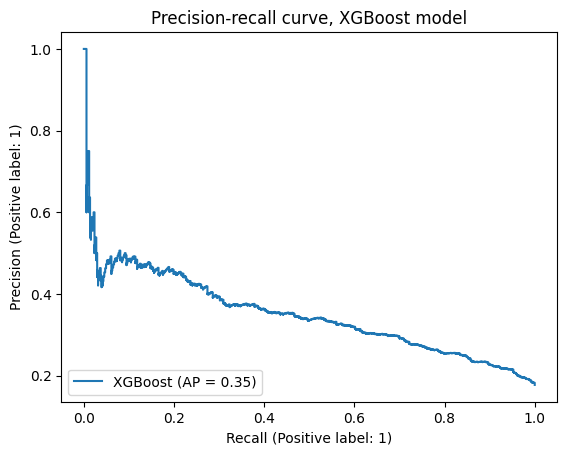

In [44]:
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');

As recall increases, precision decreases. But what if we determined that false positives aren't much of a problem? For example, in the case of this Waze project, a false positive could just mean that a user who will not actually churn gets an email and a banner notification on their phone. It's very low risk.

So, what if instead of using the default 0.5 decision threshold of the model, we used a lower threshold?

Here's an example where the threshold is set to 0.4:

In [45]:
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.6649055 , 0.3350945 ],
       [0.3051954 , 0.6948046 ],
       [0.7004608 , 0.29953918],
       ...,
       [0.3265891 , 0.6734109 ],
       [0.813565  , 0.18643497],
       [0.29744112, 0.7025589 ]], dtype=float32)

The `predict_proba()` method returns a 2-D array of probabilities where each row represents a user. The first number in the row is the probability of belonging to the negative class, the second number in the row is the probability of belonging to the positive class. (Notice that the two numbers in each row are complimentary to each other and sum to one.)

we can generate new predictions based on this array of probabilities by changing the decision threshold for what is considered a positive response. For example, the following code converts the predicted probabilities to {0, 1} predictions with a threshold of 0.4. In other words, any users who have a value ≥ 0.4 in the second column will get assigned a prediction of `1`, indicating that they churned.

In [46]:
# A list of just the second column values (probability of target)
probs = [x[1] for x in predicted_probabilities]

# An array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in probs])
new_preds

array([0, 1, 0, ..., 1, 0, 1])

In [47]:
# Get evaluation metrics for when the threshold is 0.4
get_test_scores('XGB, threshold = 0.4', new_preds, y_test)

,Model,Accuracy,Precision,Recall,F1
0,"XGB, threshold = 0.4",0.585315,0.266345,0.763314,0.394898


Compare these numbers with the results from earlier.

In [48]:
results

,Model,Accuracy,Precision,Recall,F1
0,XGB test,0.670979,0.301645,0.650888,0.412242
0,XGBoost val,0.686713,0.323021,0.700197,0.442092
0,Random Forest val,0.813986,0.426901,0.143984,0.215339
0,XGBoost CV,0.688309,0.320398,0.674767,0.434448
0,Random Forest CV,0.814198,0.431921,0.146508,0.218282


Recall score increased significantly, while precision, f1 and accuracy decreased.

So, using the precision-recall curve as a guide, suppose you knew that you'd be satisfied if the model had a recall score of 0.5 and you were willing to accept the \~35% precision score that comes with it. In other words, you'd be happy if the model successfully identified half of the people who will actually churn, even if it means that when the model says someone will churn, it's only correct about 35% of the time.

What threshold will yield this result? There are a number of ways to determine this. Here's one way that uses a function to accomplish this.

In [50]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
    Find the threshold that most closely yields a desired recall score.

    Inputs:
        y_test_data: Array of true y values
        probabilities: The results of the `predict_proba()` model method
        desired_recall: The recall that you want the model to have

    Outputs:
        threshold: The threshold that most closely yields the desired recall
        recall: The exact recall score associated with `threshold`
    '''
    probs = [x[1] for x in probabilities]  # Isolate second column of `probabilities`
    thresholds = np.arange(0, 1, 0.001)    # Set a grid of 1,000 thresholds to test

    scores = []
    for threshold in thresholds:
        # Create a new array of {0, 1} predictions based on new threshold
        preds = np.array([1 if x >= threshold else 0 for x in probs])
        # Calculate recall score for that threshold
        recall = recall_score(y_test_data, preds)
        # Append the threshold and its corresponding recall score as a tuple to `scores`
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        # Calculate how close each actual score is to the desired score
        distance = abs(score[1] - desired_recall)
        # Append the (index#, distance) tuple to `distances`
        distances.append((idx, distance))

    # Sort `distances` by the second value in each of its tuples (least to greatest)
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    # Identify the tuple with the actual recall closest to desired recall
    best = sorted_distances[0]
    # Isolate the index of the threshold with the closest recall score
    best_idx = best[0]
    # Retrieve the threshold and actual recall score closest to desired recall
    threshold, recall = scores[best_idx]

    return threshold, recall


Testing the function to find the threshold that results in a recall score closest to 0.5:

In [51]:
# Get the predicted probabilities from the champion model
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)

# Call the function
threshold_finder(y_test, probabilities, 0.8)

(0.362, 0.8007889546351085)

Setting a threshold of 0.362 will result in a recall of 0.8.

To verify, you can repeat the steps performed earlier to get the other evaluation metrics for when the model has a threshold of 0.362. Based on the precision-recall curve, a 0.5 recall score should have a precision of \~0.35.

In [52]:
# Create an array of new predictions that assigns a 1 to any value >= 0.124
probs = [x[1] for x in probabilities]
new_preds = np.array([1 if x >= 0.362 else 0 for x in probs])

# Get evaluation metrics for when the threshold is 0.124
get_test_scores('XGB, threshold = 0.362', new_preds, y_test)

,Model,Accuracy,Precision,Recall,F1
0,"XGB, threshold = 0.362",0.547203,0.25375,0.800789,0.385382


In [53]:
def set_threshold(model,model_name, threshold, x, y):
  probabilities = model.best_estimator_.predict_proba(x)
  probs = [x[1] for x in probabilities]
  new_preds = np.array([1 if x >= threshold else 0 for x in probs])
  return get_test_scores(f"{model_name}, threshold = {threshold}", new_preds, y)

In [54]:
set_threshold(xgb_cv,"XGB",0.362,X_test,y_test)

,Model,Accuracy,Precision,Recall,F1
0,"XGB, threshold = 0.362",0.547203,0.25375,0.800789,0.385382


It worked as intended.